In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)
import wandb

from Datasets import *
import utils

In [2]:
wandb.login()

wandb: Currently logged in as: jorgvt (use `wandb login --relogin` to force relogin)


True

In [75]:
config = {
    'epochs':50,
    'classes':5,
    'batch_size':32,
    'learning_rate':0.001,
    'channels':['C3','C4','O1','O2','LOC','ROC','CHIN1'],
    'patients_train':1,
    'patients_test':2,
    'metadata': "Trying generalization from patient 1 to 2 without LSTM"
}

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [32]:
path = "../Data/PSG1.edf"
test = EDFData_PTH(path, channels=config['channels'])
testloader = torch.utils.data.DataLoader(test, batch_size = config['batch_size'], drop_last=True)

In [7]:
sampling_rate = int(test.sampling_rate)
sampling_rate

512

In [71]:
class TinySleepNet(nn.Module):
    def __init__(self, sampling_rate, channels, classes):
        super(TinySleepNet, self).__init__()
        self.sampling_rate = sampling_rate
        self.channels = channels
        self.classes = classes

        self.feature_extraction = nn.Sequential(*[
            nn.Conv1d(in_channels=len(channels), out_channels=128, kernel_size=sampling_rate//2, stride=sampling_rate//4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        ])

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.classifier = nn.Linear(128*2, classes)

    def forward(self, X):
        X = self.feature_extraction(X)
        # X, _ = self.lstm(X.permute(0,2,1))
        # X = X[:,-1,:]
        X = X.view(X.shape[0],-1)
        X = self.classifier(X)
        return X

In [72]:
model = TinySleepNet(sampling_rate, config['channels'], classes=len(test.id_to_class_dict))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
model

TinySleepNet(
  (feature_extraction): Sequential(
    (0): Conv1d(7, 128, kernel_size=(256,), stride=(128,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=256, out_features=5, bias=True)
)

In [73]:
for X, Y in testloader:
    X = X.to(device).float()
    with torch.no_grad():
        pap = model(X)
    break
pap.shape

torch.Size([32, 5])

In [5]:
def train_step(model, optimizer, loss_fn, history, X, Y, metrics=None):
    """
    Trains the model over a batch.

    Parameters
    ----------
    model: nn.Module
        Torch model.
    optimizer:
        Torch optimizer.
    loss_fn:
        Torch loss function.
    X: torch.Tensor
    Y: torch.Tensor
    metrics: dict{str:functions}
        Dict of functions (metrics) we want to calculate and their name.
    
    Returns
    -------
    history: dict{str:float}
        Dictionary of metrics.
    """
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, Y)
    loss.backward()

    history['loss'] = loss.item()
    if metrics:
        with torch.no_grad():
            for name, metric_fn in metrics.items():
                history[name] = metric_fn(pred, Y)

    optimizer.step()
    return history

In [6]:
def val_step(model, optimizer, loss_fn, history, X, Y, metrics=None):
    """
    Calculates the validation metrics over a batch.

    Parameters
    ----------
    model: nn.Module
        Torch model.
    optimizer:
        Torch optimizer.
    loss_fn:
        Torch loss function.
    X: torch.Tensor
    Y: torch.Tensor
    metrics: dict{str:functions}
        Dict of functions (metrics) we want to calculate and their name.
    
    Returns
    -------
    history: dict{str:float}
        Dictionary of metrics.
    """
    with torch.no_grad():
        pred = model(X)
        loss = loss_fn(pred, Y)

        history['val_loss'] = loss.item()
        if metrics:
            for name, metric_fn in metrics.items():
                history['val_'+name] = metric_fn(pred, Y)

    return history

In [7]:
class History():
    """
    Class designed to track the metrics during the training of a NN.
    """
    
    def __init__(self):
        self.history = {}

    def update(self, history):
        """
        Adds new values to the history.

        Parameters
        ----------
        history: dict{str:float}

        Returns
        -------
        None
        """
        for metric_name, metric_value in history.items():
            if metric_name not in self.history.keys():
                self.history[metric_name] = [metric_value]
            else:
                self.history[metric_name].append(metric_value)

    def return_lasts(self):
        return {name:value[-1] for name, value in self.history.items()}
        
    
    def plot_history(self, figsize=(16,6)):
        """
        Plots the history values.

        Parameters
        ----------
        history: History object

        Returns
        -------
        None
        """
        ## First retrieve metrics names ## 
        metrics_names = [a for a in self.history.keys() if a[:3]!='val']
        
        rows = 1
        cols = len(metrics_names)

        plt.figure(figsize=figsize)
        for i,a in enumerate(metrics_names,1):
            plt.subplot(rows,cols,i)
            plt.title(a)
            plt.plot(self.history[a], label="Train")
            plt.plot(self.history["val_"+a], label="Validation")
            plt.legend()

        plt.show()

In [8]:
def accuracy_fn(Y_pred, Y_true):
    """
    Calculates the accuracy of our model given its predictions and labels.

    Parameters
    ----------
    Y_pred: torch.Tensor
        Raw output from the nn (logits).
    Y_true: torch.Tensor
        Objective labels.
    
    Returns
    -------
    accuracy: float
    """
    Y_pred = torch.softmax(Y_pred, dim=-1)
    Y_pred = Y_pred.argmax(dim=-1)
    accuracy = torch.where(Y_pred==Y_true, 1, 0).sum() / len(Y_true)

    return accuracy.item()

In [18]:
def train_fn(model, optimizer, loss_fn, trainloader, testloader, epochs, metrics, history=History, verbose=True):
    ## Tell wandb to watch the model
    wandb.watch(model, loss_fn, log="all", log_freq=10)

    history_epoch = history()

    for epoch in range(epochs):
        history_batch = history()
        for batch_i, (X, Y) in enumerate(trainloader, 1):
            X, Y = X.to(device).float(), torch.squeeze(Y).long().to(device)
            history_train = train_step(model, optimizer, loss_fn, {}, X, Y, metrics)
            history_batch.update(history_train)
            
        for batch_i, (X, Y) in enumerate(testloader, 1):
            X, Y = X.to(device).float(), torch.squeeze(Y).long().to(device)
            history_val = val_step(model, optimizer, loss_fn, {}, X, Y, metrics)
            history_batch.update(history_val)
            
        history_epoch.update({name:np.mean(values) for name,values in history_batch.history.items()})
        if verbose:
            print(f"Epoch {epoch+1} -> [Train] (Loss) {history_epoch.history['loss'][-1]:.4f} (Acc) {history_epoch.history['accuracy'][-1]:.4f} | [Val] (Loss) {history_epoch.history['val_loss'][-1]:.4f} (Acc) {history_epoch.history['val_accuracy'][-1]:.4f}")
        
        ## Log the metrics to WandB
        wandb.log(history_epoch.return_lasts())

    return history_epoch

In [10]:
def get_labels_and_preds(model, dataloader):
    """
    Gets the true and predicted labels for a given dataloader.
    """
    labels = []
    preds = []
    ## Get every prediction and label
    for X, Y in dataloader:
        X = X.to(device).float()
        with torch.no_grad():
            pred = model(X)
            pred = pred.softmax(-1).argmax(-1)
            preds.extend(pred.cpu().numpy())
            labels.extend(Y.numpy())
    
    return labels, preds

In [11]:
def plot_labels_bundle_pth(model, dataset, dataloader):
    """
    Plots the true labels and the predicted labels versus time.
    """
    preds = []
    labels = []
    ## Get every prediction and label
    for X, Y in dataloader:
        X = X.to(device).float()
        with torch.no_grad():
            pred = model(X)
            pred = pred.softmax(-1).argmax(-1)
            preds.extend(pred.cpu().numpy())
            labels.extend(Y.numpy())
    
    ## Plot the figure
    plt.figure(figsize=(20,6))
    utils.plot_labels(labels, preds, dataset.id_to_class_dict)

In [12]:
def plot_cm_bundle_pth(model, dataset, dataloader, cmap='magma'):
    """
    Plots the confusion matrix for a model trained with a dataset and dataloader.
    """
    preds = []
    labels = []
    ## Get every prediction and label
    for X, Y in dataloader:
        X = X.to(device).float()
        with torch.no_grad():
            pred = model(X)
            pred = pred.softmax(-1).argmax(-1)
            preds.extend(pred.cpu().numpy())
            labels.extend(Y.numpy())
    
    ## Plot confusion matrix
    plt.figure(figsize=(8,8))
    utils.plot_heatmaps_raw(confusion_matrix(labels, preds), precision=0, cmap=cmap)
    plt.colorbar()
    plt.xticks(range(config["classes"]), dataset.id_to_class_dict.values(), rotation=90)
    plt.yticks(range(config["classes"]), dataset.id_to_class_dict.values(), rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [13]:
def plot_cm(labels, preds, dataset, cmap='magma'):
    """
    Plots the confusion matrix for a model trained with a dataset and dataloader.
    """
    # plt.figure(figsize=(8,8))
    utils.plot_heatmaps_raw(confusion_matrix(labels, preds), precision=0, cmap=cmap)
    plt.colorbar()
    plt.xticks(range(config["classes"]), dataset.id_to_class_dict.values(), rotation=90)
    plt.yticks(range(config["classes"]), dataset.id_to_class_dict.values(), rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

Epoch 1 -> [Train] (Loss) 1.6395 (Acc) 0.3079 | [Val] (Loss) 1.6132 (Acc) 0.4183
Epoch 2 -> [Train] (Loss) 1.5346 (Acc) 0.2882 | [Val] (Loss) 1.5951 (Acc) 0.2139
Epoch 3 -> [Train] (Loss) 1.4761 (Acc) 0.2986 | [Val] (Loss) 1.7782 (Acc) 0.0312
Epoch 4 -> [Train] (Loss) 1.4820 (Acc) 0.2708 | [Val] (Loss) 1.6712 (Acc) 0.2488
Epoch 5 -> [Train] (Loss) 1.3674 (Acc) 0.3368 | [Val] (Loss) 1.7497 (Acc) 0.0312
Epoch 6 -> [Train] (Loss) 1.3064 (Acc) 0.4387 | [Val] (Loss) 2.1620 (Acc) 0.1587
Epoch 7 -> [Train] (Loss) 1.3504 (Acc) 0.3519 | [Val] (Loss) 1.8070 (Acc) 0.0829
Epoch 8 -> [Train] (Loss) 1.2639 (Acc) 0.4317 | [Val] (Loss) 2.3832 (Acc) 0.0889
Epoch 9 -> [Train] (Loss) 1.1938 (Acc) 0.4444 | [Val] (Loss) 3.1618 (Acc) 0.1502
Epoch 10 -> [Train] (Loss) 1.2328 (Acc) 0.5197 | [Val] (Loss) 2.9366 (Acc) 0.1587
Epoch 11 -> [Train] (Loss) 1.1038 (Acc) 0.5382 | [Val] (Loss) 2.4698 (Acc) 0.2416
Epoch 12 -> [Train] (Loss) 1.0782 (Acc) 0.5347 | [Val] (Loss) 3.1452 (Acc) 0.1034
Epoch 13 -> [Train] (Loss

loss,0.02585
accuracy,0.99537
val_loss,16.94076
val_accuracy,0.1875
_runtime,472
_timestamp,1624458131
_step,53


loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▄▄▃▃▂▃▃▂▂▂▂▂▃▂▁▁▁▁▁▁
accuracy,▁▁▁▁▃▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
val_loss,▁▁▁▁▁▁▁▂▁▂▂▂▂▃▃▃▂▃▃▃▄▂▄▃▄▄▄▅▇▅▇█▆▅▇▅▇▇██
val_accuracy,█▄▁▅▃▂▂▃▅▂▃▂▄▅▄▄▆▅▃▅▄▄▃▃▃▃▅▅▄▄▃▃▃▄▃▅▄▄▃▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


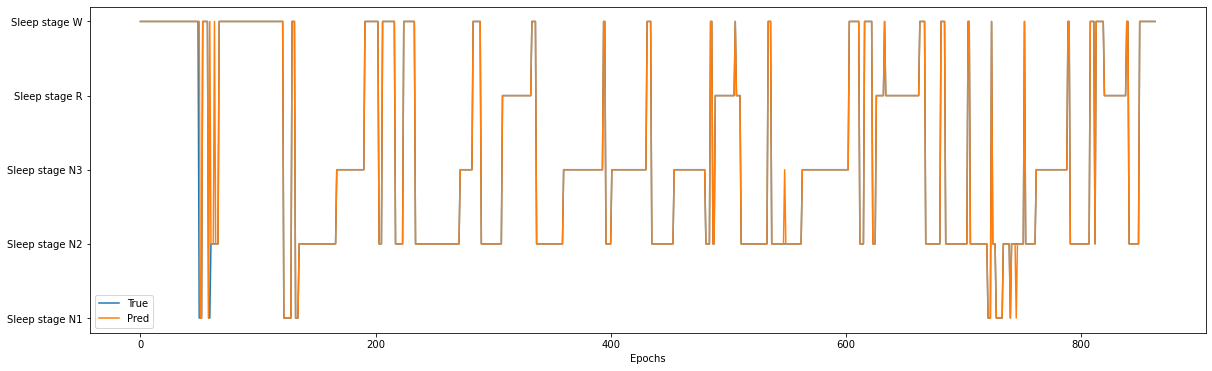

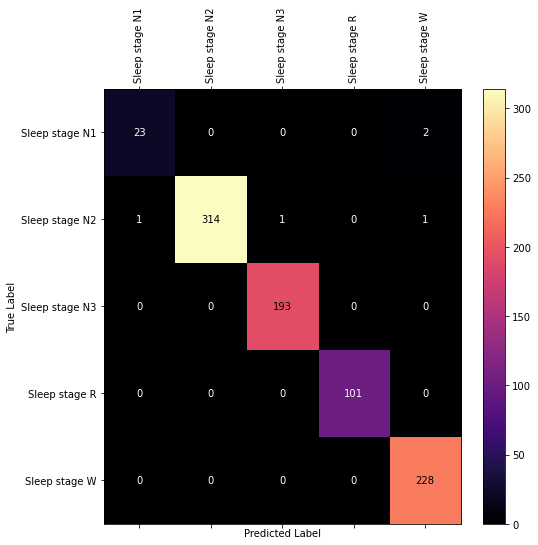

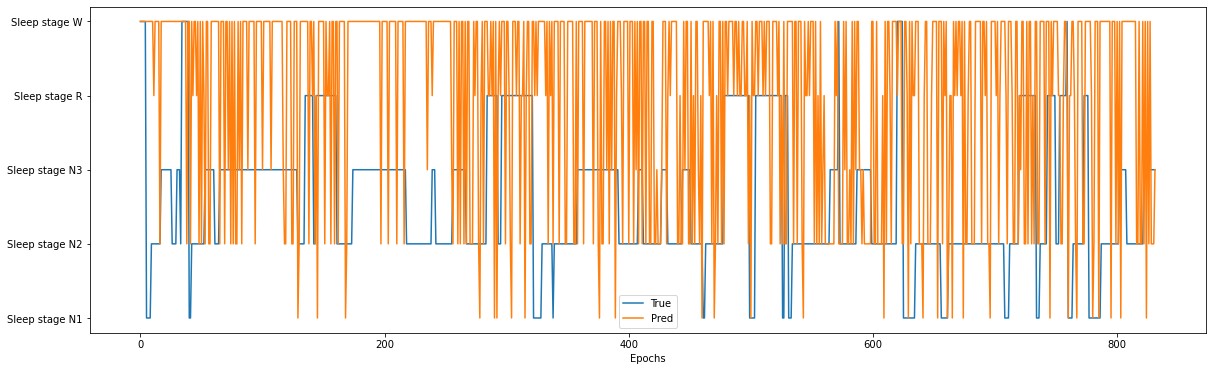

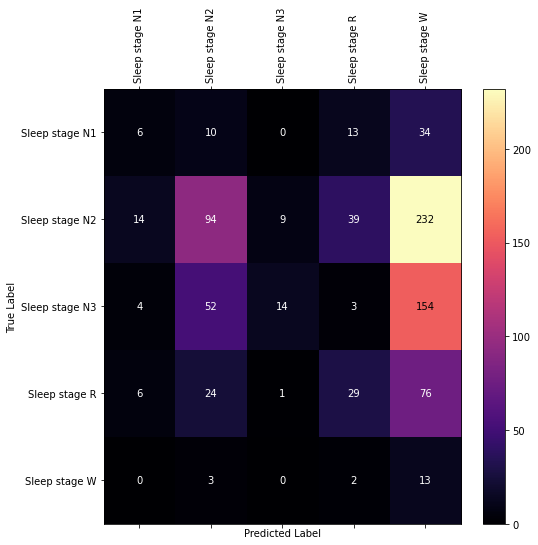

In [76]:
with wandb.init(project='test-pth', entity='jorgvt', config = config):
    configuration = wandb.config

    ## Load the data ##
    path_train = "../Data/PSG1.edf"
    path_test = "../Data/PSG2.edf"
    train = EDFData_PTH(path_train, channels=config['channels'])
    trainloader = torch.utils.data.DataLoader(train, batch_size = configuration.batch_size, drop_last=True)
    test = EDFData_PTH(path_test, channels=config['channels'])
    testloader = torch.utils.data.DataLoader(test, batch_size = configuration.batch_size, drop_last=True)
    sampling_rate = int(test.sampling_rate)

    ## Define the model ##
    model = TinySleepNet(sampling_rate, configuration.channels, classes=len(train.id_to_class_dict))
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    ## Define the metrics ##
    metrics = {
    'accuracy':accuracy_fn
    }

    ## Train the model ##
    h = train_fn(model, optimizer, loss_fn, trainloader, testloader, configuration.epochs, metrics)

    ## Get the labels and predictions for the whole datasets
    labels_train, preds_train = get_labels_and_preds(model, trainloader)
    labels_test, preds_test = get_labels_and_preds(model, testloader)
    
    ## Create and log figures
    ### Train
    plt.figure(figsize=(20,6))
    utils.plot_labels(preds_train, labels_train, label_mapper=train.id_to_class_dict)
    wandb.log({"Labels_Preds_Plot_Train":wandb.Image(plt)})
    plt.figure(figsize=(8,8))
    plot_cm(labels_train, preds_train, train)
    wandb.log({"Confusion_Matrix_Train":wandb.Image(plt)})
    ### Test
    plt.figure(figsize=(20,6))
    utils.plot_labels(preds_test, labels_test, label_mapper=train.id_to_class_dict)
    wandb.log({"Labels_Preds_Plot_Test":wandb.Image(plt)})
    plt.figure(figsize=(8,8))
    plot_cm(labels_test, preds_test, test)
    wandb.log({"Confusion_Matrix_Test":wandb.Image(plt)})